In [25]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
with open('/content/drive/MyDrive/ted-talks-corpus/train.en', 'r') as f:
    english_train = f.readlines()
with open('/content/drive/MyDrive/ted-talks-corpus/train.fr', 'r') as f:
    french_train = f.readlines()
with open('/content/drive/MyDrive/ted-talks-corpus/dev.en', 'r') as f:
    english_val = f.readlines()
with open('/content/drive/MyDrive/ted-talks-corpus/dev.fr', 'r') as f:
    french_val = f.readlines()
with open('/content/drive/MyDrive/ted-talks-corpus/test.en', 'r') as f:
    english_test = f.readlines()
with open('/content/drive/MyDrive/ted-talks-corpus/test.fr', 'r') as f:
    french_test = f.readlines()

print(english_train[:10])
print(french_train[:10])


["David Gallo: This is Bill Lange. I'm Dave Gallo.\n", "And we're going to tell you some stories from the sea here in video.\n", "We've got some of the most incredible video of Titanic that's ever been seen, and we're not going to show you any of it.\n", "The truth of the matter is that the Titanic -- even though it's breaking all sorts of box office records -- it's not the most exciting story from the sea.\n", 'And the problem, I think, is that we take the ocean for granted.\n', 'When you think about it, the oceans are 75 percent of the planet.\n', 'Most of the planet is ocean water.\n', 'The average depth is about two miles.\n', "Part of the problem, I think, is we stand at the beach, or we see images like this of the ocean, and you look out at this great big blue expanse, and it's shimmering and it's moving and there's waves and there's surf and there's tides, but you have no idea for what lies in there.\n", 'And in the oceans, there are the longest mountain ranges on the planet.\n'

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import matplotlib.pyplot as plt

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
def lens_of_data(english_train,french_train,english_val,french_val,english_test,french_test):
    print("English train:",len(english_train))
    print("French train:",len(french_train))
    print("English val:",len(english_val))
    print("French val:",len(french_val))
    print("English test:",len(english_test))
    print("French test:",len(french_test))
lens_of_data(english_train,french_train,english_val,french_val,english_test,french_test)

English train: 30000
French train: 30000
English val: 887
French val: 887
English test: 1305
French test: 1305


In [30]:
#view 5 examples against each other
def view_examples(eng_train,fr_train,eng_test,fr_test,eng_dev,fr_dev):
    for i in range(3):
        print("English Train: {} \n French Train: {} \n".format(eng_train[i].strip(), fr_train[i].strip()))
        print("English Test: {} \n French Test: {} \n".format(eng_test[i].strip(), fr_test[i].strip()))
        print("English Validation: {} \n French Validation: {} \n".format(eng_dev[i].strip(), fr_dev[i].strip()))
view_examples(english_train,french_train,english_test,french_test,english_val,french_val)

English Train: David Gallo: This is Bill Lange. I'm Dave Gallo. 
 French Train: David Gallo: Voici Bill Lange. Je suis Dave Gallo. 

English Test: When I was in my 20s, I saw my very first psychotherapy client. 
 French Test: Quand j'avais la vingtaine, j'ai vu mes tout premiers clients comme psychothérapeute. 

English Validation: You know, one of the intense pleasures of travel and one of the delights of ethnographic research is the opportunity to live amongst those who have not forgotten the old ways, who still feel their past in the wind, touch it in stones polished by rain, taste it in the bitter leaves of plants. 
 French Validation: Vous savez, un des plaisirs intenses du voyage et un des délices de la recherche ethnographique est la possibilité de vivre parmi ceux qui n'ont pas oublié les anciennes coutumes, qui ressentent encore leur passé souffler dans le vent, qui le touchent dans les pierres polies par la pluie, le dégustent dans les feuilles amères des plantes. 

English T

In [31]:
eng_train = [sent.strip().split(" ") for sent in english_train]
fr_train = [sent.strip().split(" ") for sent in french_train]
eng_test = [sent.strip().split(" ") for sent in english_test]
fr_test = [sent.strip().split(" ") for sent in french_test] 
eng_dev = [sent.strip().split(" ") for sent in english_val]
fr_dev = [sent.strip().split(" ") for sent in french_val]


In [37]:
en_idx2word = []
fr_idx2word = []
for en in [eng_train, eng_test]:
    for sent in en:
        for word in sent:
            if word not in en_idx2word:
                en_idx2word.append(word)
for fr in [fr_train, fr_test]:
    for sent in fr:
        for word in sent:
            if word not in fr_idx2word:
                fr_idx2word.append(word)
en_idx2word = ['<PAD>', '<SOS>','<EOS>'] + en_idx2word
fr_idx2word = ['<PAD>', '<SOS>','<EOS>'] + fr_idx2word
#print few words
print(en_idx2word[:10])

['<PAD>', '<SOS>', '<EOS>', 'David', 'Gallo:', 'This', 'is', 'Bill', 'Lange.', "I'm"]


In [38]:
en_word2idx = {word:idx for idx, word in enumerate(en_idx2word)}
fr_word2idx = {word:idx for idx, word in enumerate(fr_idx2word)}

In [39]:
def len_comparison(A_train,B_train):
    A_lengths = sum([len(sent) for sent in A_train])/len(A_train)
    B_lengths = sum([len(sent) for sent in B_train])/len(B_train)
    biggest_val = max(A_lengths,B_lengths)
    #round of biggest val to nearest 10
    biggest_val = round(biggest_val, -1)
    return biggest_val
seq_length = len_comparison(eng_train,fr_train)
seq_length = int(seq_length)
print(seq_length)

20


In [40]:
sequence_length = 20
def encode_and_pad(vocab, sent, max_length):
    sos = [vocab["<SOS>"]]
    eos = [vocab["<EOS>"]]
    pad = [vocab["<PAD>"]]

    if len(sent) < max_length - 2: # -2 for SOS and EOS
        n_pads = max_length - 2 - len(sent)
        encoded = [vocab[w] for w in sent]
        return sos + encoded + eos + pad * n_pads 
    else: # sent is longer than max_length; truncating
        encoded = [vocab[w] for w in sent]
        truncated = encoded[:max_length - 2]
        return sos + truncated + eos
en_train_encoded = [encode_and_pad(en_word2idx, sent, sequence_length) for sent in eng_train]
fr_train_encoded = [encode_and_pad(fr_word2idx, sent, sequence_length) for sent in fr_train]
en_test_encoded = [encode_and_pad(en_word2idx, sent, sequence_length) for sent in eng_test]
fr_test_encoded = [encode_and_pad(fr_word2idx, sent, sequence_length) for sent in fr_test]

In [41]:
import numpy as np
batch_size = 50


In [42]:
train_x = np.array(en_train_encoded)
train_y = np.array(fr_train_encoded)
test_x = np.array(en_test_encoded)
test_y = np.array(fr_test_encoded)

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

# def view_train_test(data):
#   for i, (x, y) in enumerate(data):
#       if i > 5:
#           break
#       print(x.shape, y.shape)
#       print(x[0])
#       print(y[0])
# view_train_test(train_dl)

In [43]:
# class EncoderRNN(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=0) #If specified, the entries at padding_idx do not contribute to the gradient
#         self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True) #Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
#         #If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). 
#     def forward(self, input, hidden):
#         embedded = self.embedding(input)
#         output = embedded
#         output, hidden = self.gru(output, hidden)
#         return output, hidden
#     def initHidden(self):
#         return torch.zeros(1, batch_size, self.hidden_size)
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=0)
        
        # GRU layer. The input and output are both of the same size 
        #  since embedding size = hidden size in this example
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden):
        # The inputs are first transformed into embeddings
        embedded = self.embedding(input)
        output = embedded

        # As in any RNN, the new input and the previous hidden states are fed
        #  into the model at each time step 
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        # This method is used to create the innitial hidden states for the encoder
        return torch.zeros(1, batch_size, self.hidden_size)

In [44]:
# class DecoderRNN(nn.Module):
#     def __init__(self, hidden_size, output_size):
#         super(DecoderRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0) #If specified, the entries at padding_idx do not contribute to the gradient
#         self.gru = nn.GRU(hidden_size, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)
#     def forward(self, input, hidden):
#         output, hidden = self.gru(F.relu(self.embedding(input)), hidden)
#         output = self.softmax(self.out(output[0]))
#         return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        
        # The GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size)

        # Fully-connected layer for scores
        self.out = nn.Linear(hidden_size, output_size)

        # Applying Softmax to the scores
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Feeding input through embedding layer
        output = self.embedding(input)

        # Applying an activation function (ReLu)
        output = F.relu(output)

        # Feeding input and previous hidden state
        output, hidden = self.gru(output, hidden)

        # Outputting scores from the final time-step
        output = self.softmax(self.out(output[0]))
        
        return output, hidden



In [45]:
hidden_size = 128
encoder = EncoderRNN(len(en_word2idx), hidden_size).to(device)
decoder = DecoderRNN(hidden_size, len(fr_word2idx)).to(device)
print(encoder)
print(decoder)

EncoderRNN(
  (embedding): Embedding(44975, 128, padding_idx=0)
  (gru): GRU(128, 128, batch_first=True)
)
DecoderRNN(
  (embedding): Embedding(55486, 128, padding_idx=0)
  (gru): GRU(128, 128)
  (out): Linear(in_features=128, out_features=55486, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [46]:
#create seq2seq
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, input, target, teacher_forcing_ratio=0.5):
        input_length = input.size(0)
        target_length = target.size(0)
        encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)
        encoder_outputs = encoder_outputs.to(device)
        encoder_hidden = encoder.initHidden()
        encoder_hidden = encoder_hidden.to(device)
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        decoder_input = torch.tensor([[fr_word2idx['<SOS>']]], device=device)
        decoder_input = decoder_input.to(device)
        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(target_length, decoder.hidden_size, device=device)
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoder_outputs[di] = decoder_output[0, 0]
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
        return decoder_outputs
seq2seq = Seq2Seq(encoder, decoder).to(device)
#print seq2seq architecture
print(seq2seq)

Seq2Seq(
  (encoder): EncoderRNN(
    (embedding): Embedding(44975, 128, padding_idx=0)
    (gru): GRU(128, 128, batch_first=True)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(55486, 128, padding_idx=0)
    (gru): GRU(128, 128)
    (out): Linear(in_features=128, out_features=55486, bias=True)
    (softmax): LogSoftmax(dim=1)
  )
)


In [47]:
criterion = nn.CrossEntropyLoss()
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.002)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.002)

In [48]:
losses = []
input_length = target_length = 20
SOS = en_word2idx['<SOS>']
EOS = en_word2idx['<EOS>']
PAD = en_word2idx['<PAD>']
epochs = 30


In [49]:
epochs = 7
for epoch in range(epochs):
    for idx, batch in enumerate(train_dl):

        # Creating initial hidden states for the encoder
        encoder_hidden = encoder.initHidden()

        # Sending to device 
        encoder_hidden = encoder_hidden.to(device)

        # Assigning the input and sending to device
        input_tensor = batch[0].to(device)

        # Assigning the output and sending to device
        target_tensor = batch[1].to(device)
        

        # Clearing gradients
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        # Enabling gradient calculation
        with torch.set_grad_enabled(True):
            
            # Feeding batch into encoder
            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

            # This is a placeholder tensor for decoder outputs. We send it to device as well
            dec_result = torch.zeros(target_length, batch_size, len(fr_idx2word)).to(device)

            # Creating a batch of SOS tokens which will all be fed to the decoder
            decoder_input = target_tensor[:, 0].unsqueeze(dim=0).to(device)

            # Creating initial hidden states of the decoder by copying encoder hidden states
            decoder_hidden = encoder_hidden

            # For each time-step in decoding:
            for i in range(1, target_length):
                
                # Feed input and previous hidden states 
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
                # Finding the best scoring word
                best = decoder_output.argmax(1)

                # Assigning next input as current best word
                decoder_input = best.unsqueeze(dim=0) 

                # Creating an entry in the placeholder output tensor
                dec_result[i] = decoder_output


            # Creating scores and targets for loss calculation
            scores = dec_result.transpose(1, 0)[1:].reshape(-1, dec_result.shape[2])
            targets = target_tensor[1:].reshape(-1)

            # Calculating loss
            loss = criterion(scores, targets)
            
            # Performing backprop and clipping excess gradients
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

            enc_optimizer.step()
            dec_optimizer.step()

            # Keeping track of loss
            losses.append(loss.item())
            if idx % 100 == 0:
                print(f'Epoch: {epoch}/{epochs}, Batch: {idx}/{len(train_dl)}, Loss: {sum(losses)/len(losses)}')
            # if idx % 100 == 0:
            #     print(idx, sum(losses)/len(losses))

Epoch: 0/7, Batch: 0/600, Loss: 10.920042991638184
Epoch: 0/7, Batch: 100/600, Loss: 6.632684537679842
Epoch: 0/7, Batch: 200/600, Loss: 6.175141825604794
Epoch: 0/7, Batch: 300/600, Loss: 5.987822188887486
Epoch: 0/7, Batch: 400/600, Loss: 5.877352942849632
Epoch: 0/7, Batch: 500/600, Loss: 5.802076284518975
Epoch: 1/7, Batch: 0/600, Loss: 5.742351811261423
Epoch: 1/7, Batch: 100/600, Loss: 5.660721302032471
Epoch: 1/7, Batch: 200/600, Loss: 5.596802135829473
Epoch: 1/7, Batch: 300/600, Loss: 5.550576944065411
Epoch: 1/7, Batch: 400/600, Loss: 5.512549780465506
Epoch: 1/7, Batch: 500/600, Loss: 5.477068690578035
Epoch: 2/7, Batch: 0/600, Loss: 5.450500108717284
Epoch: 2/7, Batch: 100/600, Loss: 5.408234708772816
Epoch: 2/7, Batch: 200/600, Loss: 5.37424393026936
Epoch: 2/7, Batch: 300/600, Loss: 5.342757812108618
Epoch: 2/7, Batch: 400/600, Loss: 5.316637477898583
Epoch: 2/7, Batch: 500/600, Loss: 5.295187398729992
Epoch: 3/7, Batch: 0/600, Loss: 5.2750931649258375
Epoch: 3/7, Batch: 

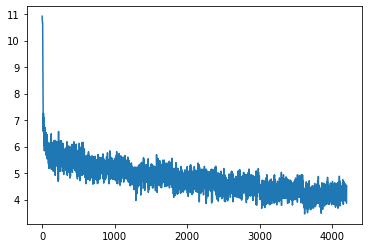

In [50]:
plt.plot(losses)
plt.savefig('m2.png')

In [54]:
#translate an input sentence
def translate(sentence,en_word2idx,fr_idx2word,sequence_length,target_length,hidden_size,enc_optimizer,dec_optimizer,encoder,decoder):
    SOS = en_word2idx['<SOS>']
    EOS = en_word2idx['<EOS>']
    test_sentence = torch.tensor(encode_and_pad(en_word2idx, sentence.split(), sequence_length)).unsqueeze(dim=0)
    encoder_hidden = torch.zeros(1, 1, hidden_size)
    encoder_hidden = encoder_hidden.to(device)
    input_tensor = test_sentence.to(device)
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    result = []
    encoder_outputs = torch.zeros(sequence_length, encoder.hidden_size, device=device)
    with torch.set_grad_enabled(False):
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
        dec_result = torch.zeros(target_length, 1, len(fr_idx2word)).to(device)
        decoder_input = torch.tensor([SOS]).unsqueeze(dim=0).to(device)
        decoder_hidden = encoder_hidden
        for di in range(1, target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            best = decoder_output.argmax(1)
            result.append(fr_idx2word[best.to('cpu').item()])
            if best.item() == EOS:
                break

            decoder_input = best.unsqueeze(dim=0) 
            dec_result[di] = decoder_output

        scores = dec_result.reshape(-1, dec_result.shape[2])
        targets = target_tensor.reshape(-1)
    return result
# sentence = 'But see all those different working things?'
# predicted = translate(sentence,en_word2idx,fr_idx2word,sequence_length,target_length,hidden_size,enc_optimizer,dec_optimizer,encoder,decoder)
# predicted = " ".join(predicted)
# predicted



In [52]:
pred_list = []
for train_sent in english_test:
  predicted = translate(train_sent,en_word2idx,fr_idx2word,sequence_length,target_length,hidden_size,enc_optimizer,dec_optimizer,encoder,decoder)
  predicted = " ".join(predicted)
  pred_list.append(predicted)
print(pred_list[:2])


["J'ai j'ai j'ai j'ai j'ai j'ai de j'ai de j'ai de ma ma <EOS>", 'Je suis une dans dans dans dans dans de <EOS>']


In [55]:
with open('your_file1.txt', 'w') as f:
    for item in pred_list:
        f.write("%s\n" % item)

In [56]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
def bleu_score(target, pred):
    pred = pred.strip().split(" ")
    target = [target.strip().split(" ")]
    return sentence_bleu(target, pred)
total_p = []
total_t = []
scores = []
for i in range(len(english_test)):
  scores.append(bleu_score(french_test[i],pred_list[i]))
  total_p.append(pred_list[i].strip().split(" "))
  total_t.append([french_test[i].strip().split(" ")])
val = corpus_bleu(total_t, total_p)
val

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.0068930998863544115

In [57]:
file1 = open("2020114017_MT1_test.txt","w")#write mode
file1.write(str(val) + "\n")
for i in range(len(pred_list)):
    file1.write(pred_list[i]+'\t'+str(scores[i])+'\n')
file1.close()